In [17]:
import ifm3dpy
from ifm3dpy.device import Device, O3D, O3X
from ifm3dpy.framegrabber import  FrameGrabber, buffer_id
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RectBivariateSpline

# Image Rectification

This Jupyter notebook demonstrates how to perform image rectification on an
O3D303's amplitude image, using the camera's inverse intrinsics and the camera
model of the O3D303.

The O3D303 camera model is based on the model described in this document:
http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/parameters.html

In [20]:
cam = O3D()
fg = FrameGrabber(cam)
fg.start([buffer_id.AMPLITUDE_IMAGE,buffer_id.INVERSE_INTRINSIC_CALIBRATION])

In [21]:
# Capture a frame and save references to the components
[ok,frame] = fg.wait_for_frame().wait_for(1500)

if not ok:
    raise RuntimeError("Timeout while waiting for a frame")

amp = frame.get_buffer(buffer_id.AMPLITUDE_IMAGE)
inv_cal =frame.get_buffer(buffer_id.INVERSE_INTRINSIC_CALIBRATION)

In [22]:
# Unpack intrinsics values
fx, fy, mx, my, alpha, k1, k2, k5, k3, k4, *_ = np.array(frame.get_buffer(buffer_id.INVERSE_INTRINSIC_CALIBRATION)[0],dtype=float)

# Create the camera matrix
# If the current application is using the 23k imager, fx/fy/mx/my must be divided by two.
# If the current application is using the full resolution imager, fx/fy/mx/my can be used 'as-is'
settings = cam.to_json()
if settings['ifm3d']['Apps'][cam.active_application() - 1]['Imager']['Resolution'] == '0':
    KKNoAlpha = np.array([[fx/2, 0.0,  mx/2],
                          [0,    fy/2, my/2],
                          [0,    0,    1]])
else:
    KKNoAlpha = np.array([[fx, 0.0, mx],
                          [0,  fy,  my],
                          [0,  0,   1]])

# Generate the pixel coordinates
px,py = np.meshgrid(np.arange(0, amp.shape[1]),
                    np.arange(0, amp.shape[0]))

# Homogeneous coordinates
coords = np.hstack([px.reshape(-1,1) + 0.5, py.reshape(-1,1) + 0.5, np.ones([px.size, 1])]).T

# Transfer into a normalized coordinate frame
# (f=1, origin is the center, Dim: -1..1)
coords_norm = np.linalg.solve(KKNoAlpha, coords)

In [24]:
# Apply distortion
R2 = np.square(coords_norm[0]) + np.square(coords_norm[1])
R4 = np.square(R2)
R6 = np.power(R2,3)
radial_dist = 1 + k1*R2 + k2*R4 + k5*R6

a1 = 2*coords_norm[0]*coords_norm[1]
a2 = R2 + 2*np.square(coords_norm[0])
a3 = R2 + 2*np.square(coords_norm[1])
tangential_dist = np.vstack([k3*a1 + k4*a2, k3*a3 + k4*a1])

coord_dist = np.vstack([np.ones([2,1])*radial_dist*coords_norm[0:2] + tangential_dist,
                       np.ones([1,px.size])])

# Transformer --> Pixel
KK = KKNoAlpha
KK[0,1] = fx*alpha
#KK[0,1] = alpha
coord_dist = KK.dot(coord_dist)

In [25]:
f = RectBivariateSpline(np.arange(0, amp.shape[0]),
                        np.arange(0, amp.shape[1]),
                        amp)
rectified = f(coord_dist[1]-0.5, coord_dist[0]-0.5, grid=False)
amp_rectified = rectified.reshape(amp.shape)

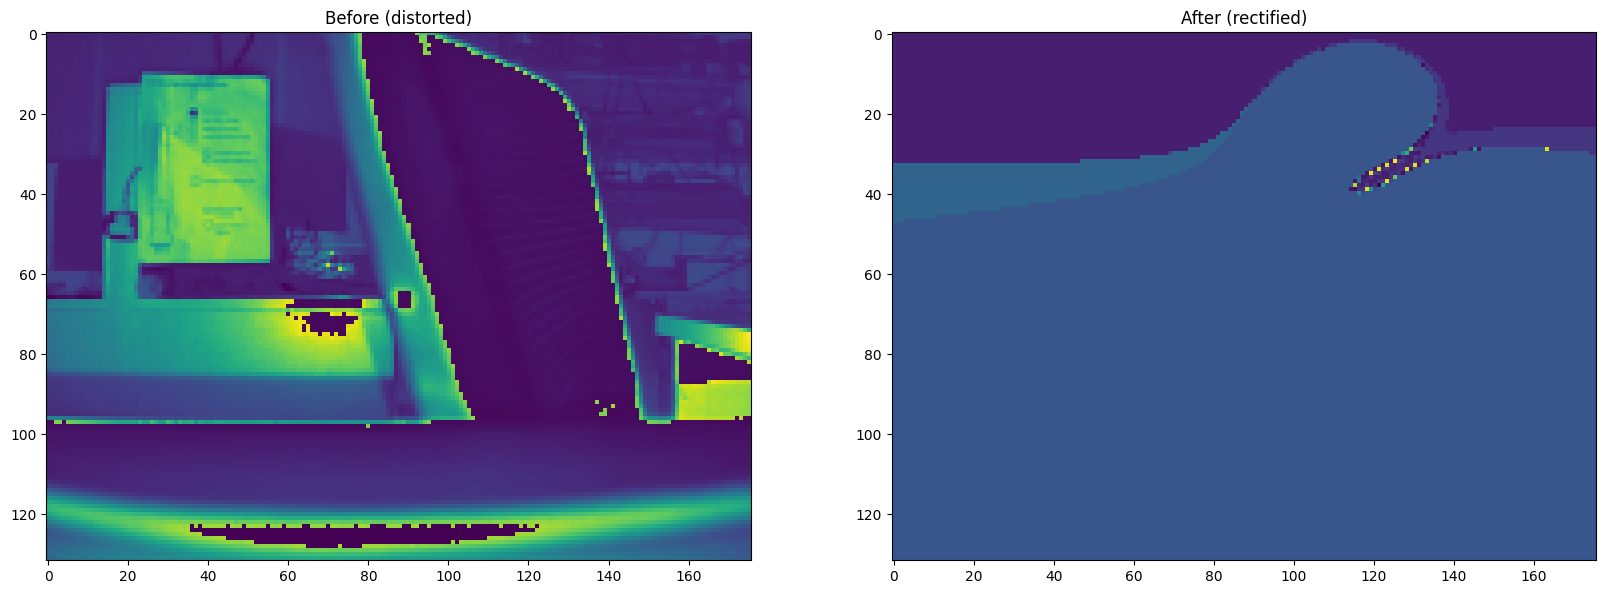

In [26]:
fig=plt.figure(figsize=(20,18))
plt.subplot(1,2,1)
plt.imshow(amp)
t = plt.title('Before (distorted)')
plt.subplot(1,2,2)
plt.imshow(amp_rectified)
t = plt.title('After (rectified)')